In [3]:
%pylab inline

import os
import keras
import metrics
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from imageio import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

Populating the interactive namespace from numpy and matplotlib


In [4]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [6]:
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'data', 'MNIST')

In [7]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [8]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


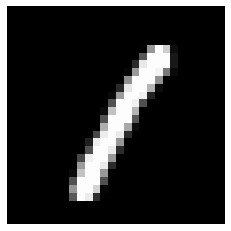

In [15]:
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'images', img_name)

img = imread(filepath, as_gray=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()



In [17]:
img.shape

(28, 28)

In [16]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'images', img_name)
    img = imread(image_path, as_gray=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

train_x /= 255.0
train_x = train_x.reshape(-1, 784).astype('float32')

In [18]:
train_y = train.label.values

In [19]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [20]:
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20)

In [21]:
km.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
pred = km.predict(val_x)

In [23]:
normalized_mutual_info_score(val_y, pred)

/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.49702246628189856

In [24]:
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              22000     
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1000

In [26]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')

In [29]:
train_history = autoencoder.fit(train_x, train_x, epochs=100, batch_size=2048, validation_data=(val_x, val_x))

Train on 34300 samples, validate on 14700 samples
Epoch 1/10
34300/34300 [==============================] - 4s 115us/step - loss: 0.0298 - val_loss: 0.0299
Epoch 2/10
34300/34300 [==============================] - 4s 121us/step - loss: 0.0291 - val_loss: 0.0285
Epoch 3/10
34300/34300 [==============================] - 4s 123us/step - loss: 0.0279 - val_loss: 0.0280
Epoch 4/10
34300/34300 [==============================] - 4s 121us/step - loss: 0.0276 - val_loss: 0.0269
Epoch 5/10
34300/34300 [==============================] - 4s 125us/step - loss: 0.0262 - val_loss: 0.0259
Epoch 6/10
34300/34300 [==============================] - 4s 128us/step - loss: 0.0258 - val_loss: 0.0261
Epoch 7/10
34300/34300 [==============================] - 5s 149us/step - loss: 0.0250 - val_loss: 0.0248
Epoch 8/10
34300/34300 [==============================] - 5s 150us/step - loss: 0.0241 - val_loss: 0.0240
Epoch 9/10
34300/34300 [==============================] - 5s 151us/step - loss: 0.0237 - val_loss: 0.0

In [30]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [31]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [32]:
normalized_mutual_info_score(val_y, pred)

/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.515053669179042

In [36]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred


# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 2048
maxiter = 100
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 25
pretrain_epochs = 100
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[train_x.shape[-1], 500, 500, 2000, 10], n_clusters=10, init=init)

dec.pretrain(x=train_x, y=train_y, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/10
34300/34300 [==============================] - 4s 111us/step - loss: 0.0820


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.1797,  nmi: 0.0931  <==|
Epoch 2/10
34300/34300 [==============================] - 4s 109us/step - loss: 0.0644


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.1902,  nmi: 0.0989  <==|
Epoch 3/10
34300/34300 [==============================] - 5s 149us/step - loss: 0.0636


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.1793,  nmi: 0.0866  <==|
Epoch 4/10
34300/34300 [==============================] - 4s 127us/step - loss: 0.0634


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.2209,  nmi: 0.1235  <==|
Epoch 5/10
34300/34300 [==============================] - 4s 115us/step - loss: 0.0612


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.2748,  nmi: 0.2046  <==|
Epoch 6/10
34300/34300 [==============================] - 4s 120us/step - loss: 0.0571


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.4195,  nmi: 0.3639  <==|
Epoch 7/10
34300/34300 [==============================] - 5s 154us/step - loss: 0.0519


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.4277,  nmi: 0.3654  <==|
Epoch 8/10
34300/34300 [==============================] - 5s 157us/step - loss: 0.0480


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.5260,  nmi: 0.4316  <==|
Epoch 9/10
34300/34300 [==============================] - 5s 153us/step - loss: 0.0428


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.4294,  nmi: 0.4324  <==|
Epoch 10/10
34300/34300 [==============================] - 4s 114us/step - loss: 0.0380


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


        |==>  acc: 0.5455,  nmi: 0.4648  <==|
Pretraining time:  110.16003656387329
Pretrained weights are saved to results/ae_weights.h5


In [37]:
dec.model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110
Trainable params: 1,665,110
Non-trainable params: 0
_________________________________________________

In [38]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [41]:
y_pred = dec.fit(train_x, y=train_y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 5
Save interval 83.740234375
Initializing cluster centers with k-means.


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.49096, nmi = 0.42283, ari = 0.30934  ; loss= 0
saving model to: results/DEC_model_0.h5


/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5: acc = 0.49318, nmi = 0.42050, ari = 0.31161  ; loss= 0
saving model to: results/DEC_model_final.h5


In [42]:
pred_val = dec.predict(val_x)

In [43]:
normalized_mutual_info_score(val_y, pred_val)

/home/jalfaizy/miniconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.40744934405662664